## Second round of cell filtering after SCRAN normalization

As SCRAN, our normalization method, creates extreme outputs for some cells (cells with a relatively low number of genes detected, maybe empty droplets?), we filter those out after SCRAN normalization. SCRAN normalization itself was performed without notebook, using a python script you can find in the scripts folder of the repository.

#### load modules

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

for pretty code formatting, but not needed to run the notebook:

In [2]:
%load_ext lab_black

#### set paths:

In [2]:
# input data
path_scran_normalized_data = "../../data/HLCA_core_h5ads/HLCA_v1_intermediates/LCA_Bano_Barb_Jain_Kras_Lafy_Meye_Mish_MishBud_Nawi_Seib_Teic_SCRAN_normalized.h5ad"
# filtered out cells output
path_cells_removed_data = "../../data/HLCA_core_h5ads/HLCA_v1_intermediates/LCA_Bano_Barb_Jain_Kras_Lafy_Meye_Mish_MishBud_Nawi_Seib_Teic_SCRAN_normalized_cells_removed.h5ad"
# cells that passed filtering output
path_scran_filtered_data = "../../data/HLCA_core_h5ads/HLCA_v1_intermediates/LCA_Bano_Barb_Jain_Kras_Lafy_Meye_Mish_MishBud_Nawi_Seib_Teic_SCRAN_normalized_filt.h5ad"

#### perform filtering:

import scran-normalized adata

In [3]:
adata = sc.read(path_scran_normalized_data)

check SCRAN results:

size factor should not be 0 anywhere:

In [5]:
sum(adata.obs.size_factors == 0)

0

check some normalized counts:

In [6]:
adata.X[0, :7].toarray(0)

array([[0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        4.762346]])

their raw counterparts:

In [7]:
adata.layers["counts"][0, :7].toarray()

array([[0., 0., 0., 0., 0., 0., 3.]], dtype=float32)

and the normalized counts multiplied by size factors, to check if these recreate the raw counts:

In [8]:
adata.X[0, :7].toarray() * adata.obs.size_factors[0]

array([[0., 0., 0., 0., 0., 0., 3.]])

sanity check: total counts should correlate well with size factor:

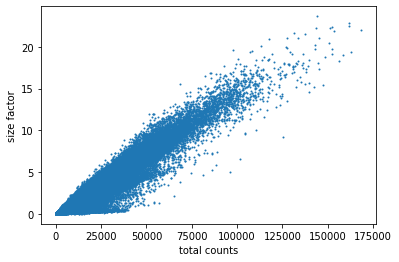

In [9]:
plt.scatter(adata.obs.total_counts, adata.obs.size_factors, s=1)
plt.xlabel("total counts")
plt.ylabel("size factor")
plt.show()

calculate post-normalization total counts:

In [5]:
new_totals = np.array(np.sum(adata.X, axis=1))

check distribution (there are few cells with very high total counts, we need to filter those):

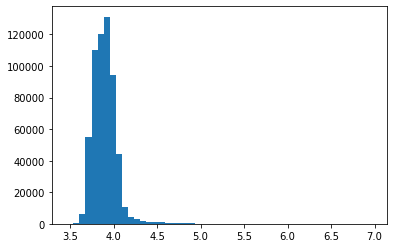

In [11]:
plt.hist(np.log10(new_totals), bins=50)
plt.show()

In [12]:
np.max(new_totals)

9217833.212816771

exploratory plots, red lines represent filtering settings (max_log10(total counts post normalization)=10**5, min_size_factor=0.01)

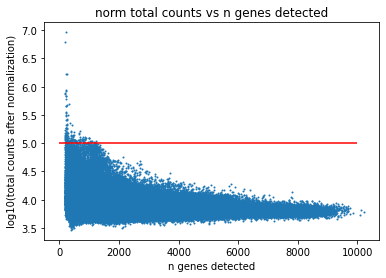

In [13]:
plt.scatter(
    adata.obs.n_genes_detected.values,
    np.log10(new_totals),
    s=1,
)
plt.hlines(y=5, xmin=0, xmax=10000, color="red")
plt.xlabel("n genes detected")
plt.ylabel("log10(total counts after normalization)")
plt.title("norm total counts vs n genes detected")
plt.show()

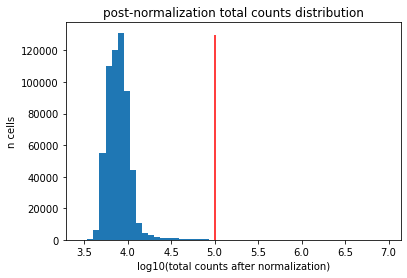

In [14]:
plt.hist(np.log10(new_totals), bins=50)
plt.xlabel("log10(total counts after normalization)")
plt.ylabel("n cells")
plt.vlines(x=5, ymin=0, ymax=130000, color="red")
plt.title("post-normalization total counts distribution")
plt.show()

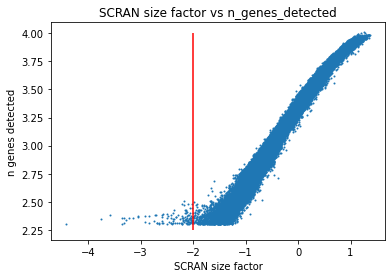

In [15]:
plt.scatter(np.log10(adata.obs.size_factors), np.log10(adata.obs.n_genes_detected), s=1)
plt.vlines(x=np.log10(0.01), ymin=2.25, ymax=4, color="red")
plt.xlabel("SCRAN size factor")
plt.ylabel("n genes detected")
plt.title("SCRAN size factor vs n_genes_detected")
plt.show()

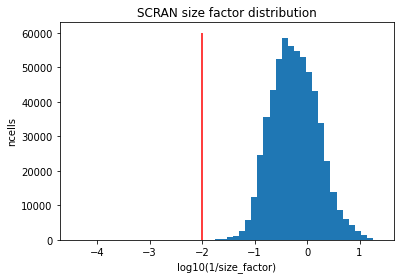

In [16]:
plt.hist(np.log10(adata.obs.size_factors), bins=50)
plt.xlabel("log10(1/size_factor)")
plt.ylabel("ncells")
plt.vlines(x=np.log10(0.01), ymin=0, ymax=60000, color="red")
plt.title("SCRAN size factor distribution")
plt.show()

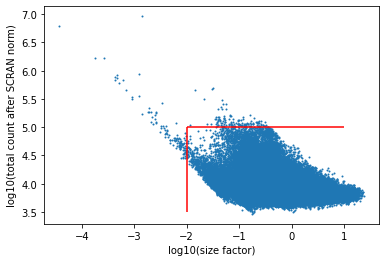

In [17]:
plt.scatter(np.log10(adata.obs.size_factors.values), np.log10(new_totals), s=1)
plt.vlines(x=np.log10(0.01), ymin=3.5, ymax=5, color="red")
plt.hlines(y=5, xmin=-2, xmax=1, color="red")
plt.xlabel("log10(size factor)")
plt.ylabel("log10(total count after SCRAN norm)")
plt.show()

filter:

In [6]:
cells_to_filter_out = adata[
    [
        norm_total_count_filter or sf_filter
        for norm_total_count_filter, sf_filter in zip(
            (new_totals > 10 ** 5).flatten().tolist(), adata.obs.size_factors < 0.01
        )
    ],
    :,
].copy()

check number of cells filtered out, dataset source and cell type:

In [7]:
cells_to_filter_out

AnnData object with n_obs × n_vars = 267 × 28527
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new'

In [8]:
cells_to_filter_out.obs.study.value_counts()

Barbry_Leroy_2020         232
Lafyatis_Rojas_2019        25
Nawijn_2021                 4
Krasnow_2020                3
Misharin_2021               2
Misharin_Budinger_2018      1
Name: study, dtype: int64

In [9]:
cells_to_filter_out.obs.ann_level_3.value_counts()

Submucosal Secretory     93
Basal                    50
Secretory                41
Ciliated                 35
B cell lineage           22
AT2                      13
1_Endothelial             3
Rare                      2
AT1                       2
1_Proliferating cells     2
T cell lineage            1
Monocytes                 1
Macrophages               1
Dendritic cells           1
Name: ann_level_3, dtype: int64

#### Store removed cells and remaining cells:

In [ ]:
# store cells that are filtered out:
cells_to_filter_out.write(path_cells_removed_data)

remove filtered cells from data:

In [10]:
filter_boolean = ~adata.obs.index.isin(cells_to_filter_out.obs.index)

In [11]:
adata.n_obs

587563

In [12]:
adata = adata[filter_boolean, :].copy()

In [13]:
adata.n_obs

587296

store resulting anndata object:

In [14]:
adata.write(path_scran_filtered_data)